In [266]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [267]:
df_train = pd.read_csv('application_record.csv')
df_test = pd.read_csv('credit_record.csv')

In [268]:
df_train.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [269]:
df_test.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [270]:
df_train.nunique()

ID                     438510
CODE_GENDER                 2
FLAG_OWN_CAR                2
FLAG_OWN_REALTY             2
CNT_CHILDREN               12
AMT_INCOME_TOTAL          866
NAME_INCOME_TYPE            5
NAME_EDUCATION_TYPE         5
NAME_FAMILY_STATUS          5
NAME_HOUSING_TYPE           6
DAYS_BIRTH              16379
DAYS_EMPLOYED            9406
FLAG_MOBIL                  1
FLAG_WORK_PHONE             2
FLAG_PHONE                  2
FLAG_EMAIL                  2
OCCUPATION_TYPE            18
CNT_FAM_MEMBERS            13
dtype: int64

In [271]:
df_test.nunique()

ID                45985
MONTHS_BALANCE       61
STATUS                8
dtype: int64

In [272]:
df_train.isna().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64

In [273]:
df_test.isnull().sum()

ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [274]:
# Fill missing values
df_train['OCCUPATION_TYPE'].fillna(value='Other', inplace=True)

In [275]:
# Dropping duplicate values
df_train=df_train.drop_duplicates(subset=df_train.columns[1:], keep='first')

In [276]:
df_train.drop('FLAG_MOBIL',axis=1,inplace=True)

In [277]:
# Construct target
df_test['target']=df_test['STATUS']
df_test['target'].replace('X', 0, inplace=True)
df_test['target'].replace('C', 0, inplace=True)
df_test['target']=df_test['target'].astype(int)
df_test.loc[df_test['target']>=1,'target']=1

# target=1 (high risk) iff there is at least one month where user is late on payments by 30 days or more
target_df=pd.DataFrame(df_test.groupby(['ID'])['target'].agg(max)).reset_index()

# Merge dataframes
new_df=pd.merge(df_train, target_df, how='inner', on=['ID'])

In [278]:
# Extract how many months account has been open for
start_df=pd.DataFrame(df_test.groupby(['ID'])['MONTHS_BALANCE'].agg(min)).reset_index()

# Rename column
start_df.rename(columns={'MONTHS_BALANCE':'ACCOUNT_LENGTH'}, inplace=True)

# Make entries positive
start_df['ACCOUNT_LENGTH']=-start_df['ACCOUNT_LENGTH']

# Merge dataframes on ID
new_df=pd.merge(new_df, start_df, how='inner', on=['ID'])

In [279]:
# Create age feature
new_df['AGE_YEARS']=-new_df['DAYS_BIRTH']/365.2425
new_df.drop('DAYS_BIRTH', axis=1, inplace=True)

# Create unemployed indicator
new_df['UNEMPLOYED']=0
new_df.loc[-new_df['DAYS_EMPLOYED']<0,'UNEMPLOYED']=1

# Create years employed feature
new_df['YEARS_EMPLOYED']=-new_df['DAYS_EMPLOYED']/365.2425
new_df.loc[new_df['YEARS_EMPLOYED']<0,'YEARS_EMPLOYED']=0
new_df.drop('DAYS_EMPLOYED', axis=1, inplace=True)

In [280]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9709 entries, 0 to 9708
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   9709 non-null   int64  
 1   CODE_GENDER          9709 non-null   object 
 2   FLAG_OWN_CAR         9709 non-null   object 
 3   FLAG_OWN_REALTY      9709 non-null   object 
 4   CNT_CHILDREN         9709 non-null   int64  
 5   AMT_INCOME_TOTAL     9709 non-null   float64
 6   NAME_INCOME_TYPE     9709 non-null   object 
 7   NAME_EDUCATION_TYPE  9709 non-null   object 
 8   NAME_FAMILY_STATUS   9709 non-null   object 
 9   NAME_HOUSING_TYPE    9709 non-null   object 
 10  FLAG_WORK_PHONE      9709 non-null   int64  
 11  FLAG_PHONE           9709 non-null   int64  
 12  FLAG_EMAIL           9709 non-null   int64  
 13  OCCUPATION_TYPE      9709 non-null   object 
 14  CNT_FAM_MEMBERS      9709 non-null   float64
 15  target               9709 non-null   i

In [281]:
new_df.nunique()

ID                     9709
CODE_GENDER               2
FLAG_OWN_CAR              2
FLAG_OWN_REALTY           2
CNT_CHILDREN              9
AMT_INCOME_TOTAL        263
NAME_INCOME_TYPE          5
NAME_EDUCATION_TYPE       5
NAME_FAMILY_STATUS        5
NAME_HOUSING_TYPE         6
FLAG_WORK_PHONE           2
FLAG_PHONE                2
FLAG_EMAIL                2
OCCUPATION_TYPE          19
CNT_FAM_MEMBERS          10
target                    2
ACCOUNT_LENGTH           61
AGE_YEARS              7172
UNEMPLOYED                2
YEARS_EMPLOYED         3637
dtype: int64

In [282]:
# Renaming Feature Columns 

new_df = new_df.rename(columns={
    'CODE_GENDER': 'Gender', 
    'FLAG_OWN_CAR': 'Own_car', 
    'FLAG_OWN_REALTY':'Own_property',
    'CNT_CHILDREN':'Num_children',
    'AMT_INCOME_TOTAL':'Total_income',
    'NAME_INCOME_TYPE':'Income_type',
    'NAME_EDUCATION_TYPE':'Education_type',
    'NAME_FAMILY_STATUS':'Marital_status',
    'NAME_HOUSING_TYPE':'Housing_type',
    'FLAG_WORK_PHONE':'Work_phone',
    'FLAG_PHONE':'Phone',
    'FLAG_EMAIL':'Email',
    'OCCUPATION_TYPE':'Occupation_type',
    'CNT_FAM_MEMBERS':'Num_family',
    'target':'Target',
    'ACCOUNT_LENGTH':'Account_length',
    'AGE_YEARS':'Age',
    'UNEMPLOYED':'Unemployed',
    'YEARS_EMPLOYED':'Years_employed'})

In [283]:
# Rearranging the Columns

new_df=new_df[['ID', 'Gender', 'Own_car', 'Own_property', 'Work_phone',
               'Phone', 'Email', 'Unemployed', 'Num_children', 'Num_family', 
               'Account_length', 'Total_income', 'Age', 'Years_employed',  
               'Income_type', 'Education_type', 'Marital_status',
               'Housing_type', 'Occupation_type','Target']]

In [284]:
# Outlier Handling

feat_with_outliers = ['Family member count','Income', 'Employment length']

def transform(self,new_df):
        if (set(self.feat_with_outliers).issubset(new_df.columns)):
            # 25% quantile
            Q1 = new_df[self.feat_with_outliers].quantile(.25)
            # 75% quantile
            Q3 = new_df[self.feat_with_outliers].quantile(.75)
            IQR = Q3 - Q1
            # keep the data within 3 IQR
            new_df = new_df[~((new_df[self.feat_with_outliers] < (Q1 - 3 * IQR)) |(new_df[self.feat_with_outliers] > (Q3 + 3 * IQR))).any(axis=1)]
            return new_df

<Axes: >

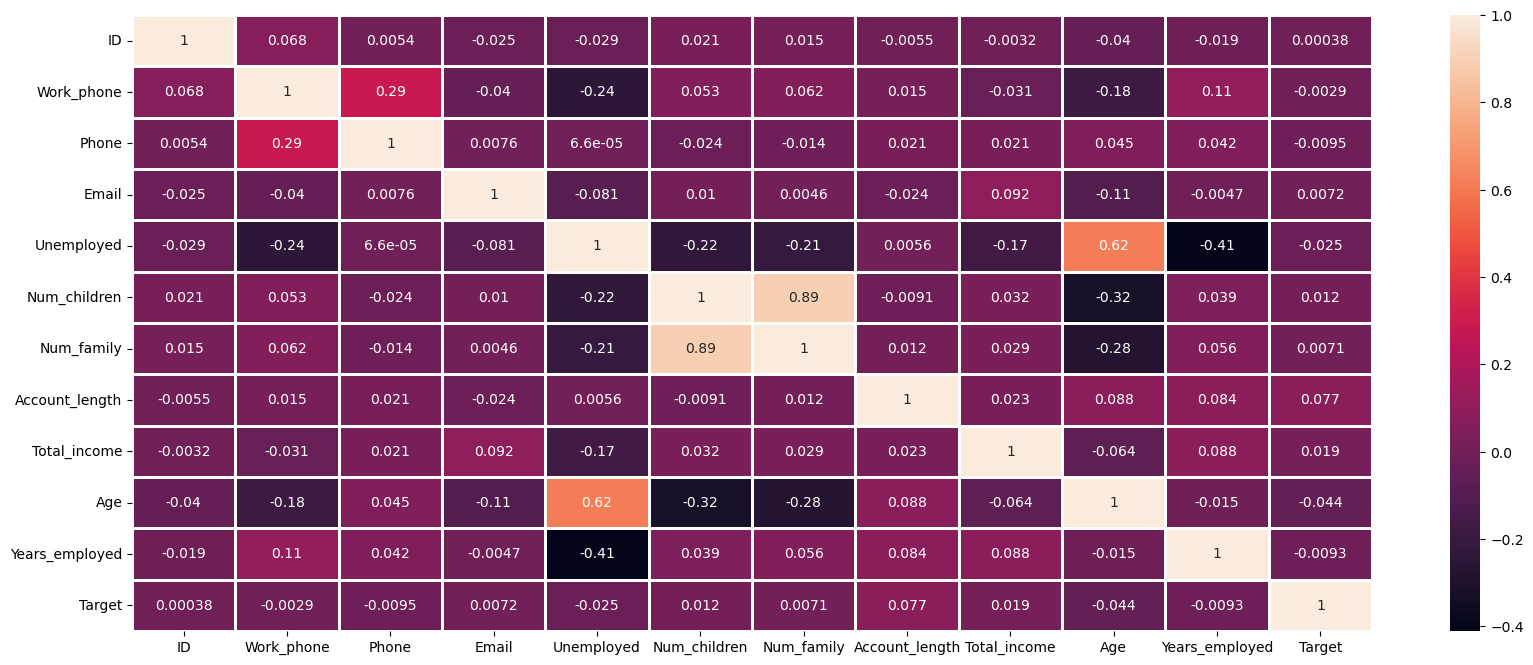

In [285]:
# Correlation 

plt.figure(figsize=(20,8))
sns.heatmap(new_df.corr(),annot=True,linewidths=2)

In [286]:
# Dropping Feature Columns

new_df = new_df.drop(['ID','Phone','Num_children','Occupation_type','Account_length'],axis=1)

Why are we droping these features?

1. ID: ID is not useful for prediction, it helped us when we were merging the two datasets but after that, there is no need to keep it.
2. Phone: Since everyone has a mobile phone, this feature does not inform us about anything.
3. Num_children: is highly correlated with Family member count, and to avoid multicollinearity, we drop it.
4. Occupation_type: Has some missing values and the count of each category is not very different to justify the use of mode. So we drop it.
5. Account_length: Because account was used to create the target, reusing will make our model to overfit. Plus, this information is unknown while applying for a credit card.

In [287]:
# Categroical to numerical encoding (Using Get Dummies)

df_ohe = pd.get_dummies(new_df[['Gender','Own_car', 'Own_property', 'Work_phone']])
df_ohe

# Concatinating two dfs
new_df = pd.concat([new_df,df_ohe],axis=1)

# Dropping Columns
new_df.drop(['Gender','Own_car', 'Own_property', 'Work_phone'],axis=1,inplace=True)

In [288]:
# Label Encoding Categorical Columns

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
new_df['Income_type'] = le.fit_transform(new_df['Income_type']) 
new_df['Education_type'] = le.fit_transform(new_df['Education_type']) 
new_df['Marital_status'] = le.fit_transform(new_df['Marital_status']) 
new_df['Housing_type'] = le.fit_transform(new_df['Housing_type']) 

In [289]:
new_df.columns

Index(['Email', 'Unemployed', 'Num_family', 'Total_income', 'Age',
       'Years_employed', 'Income_type', 'Education_type', 'Marital_status',
       'Housing_type', 'Target', 'Gender_F', 'Gender_M', 'Own_car_N',
       'Own_car_Y', 'Own_property_N', 'Own_property_Y'],
      dtype='object')

In [290]:
# Rearranging Columns once again

new_df = new_df[['Email', 'Unemployed', 'Num_family', 'Total_income', 'Age',
       'Years_employed', 'Income_type', 'Education_type', 'Marital_status',
       'Housing_type', 'Gender_F', 'Gender_M', 'Own_car_N',
       'Own_car_Y', 'Own_property_N', 'Own_property_Y','Target']]

In [291]:
new_df.head()

,Email,Unemployed,Num_family,Total_income,Age,Years_employed,Income_type,Education_type,Marital_status,Housing_type,Gender_F,Gender_M,Own_car_N,Own_car_Y,Own_property_N,Own_property_Y,Target
0,0,0,2.0,427500.0,32.868574,12.435574,4,1,0,4,0,1,0,1,0,1,1
1,0,0,2.0,112500.0,58.793815,3.104787,4,4,1,1,0,1,0,1,0,1,0
2,1,0,1.0,270000.0,52.321403,8.353354,0,4,3,1,1,0,1,0,0,1,0
3,0,1,1.0,283500.0,61.504343,0.000000,1,1,2,1,1,0,1,0,0,1,0
4,1,0,2.0,270000.0,46.193967,2.105450,4,1,1,1,0,1,0,1,0,1,0


In [292]:
# Splitting into feature and target columns 

features = new_df.iloc[:,:-1]
target = new_df.iloc[:,-1]

Interpretation:

1. There is no feature that is correlated with the target feature
2. Family member count is highly correlated with children count as previously discussed
3. Age has some positive correlation with the family member count and children count. The older a person is, the most likely he/she will have a larger family.
4. Another positive correlation is having a phone and having a work phone.
5. The final positive correlation is between the age and work phone. The younger someone is the less likely he/she will have a work phone.
6. We also have a negative correlation between the employment length and the age as previously seen.

In [293]:
# OverSampling

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
x_sample,y_sample = ros.fit_resample(features,target)

In [294]:
target.value_counts()

0    8426
1    1283
Name: Target, dtype: int64

In [295]:
y_sample.value_counts()

1    8426
0    8426
Name: Target, dtype: int64

In [296]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(x_sample,y_sample,random_state=2,test_size=0.3)

In [297]:
def mymodel(model):
    model.fit(xtrain,ytrain)
    ypred = model.predict(xtest)
    
    train = model.score(xtrain,ytrain)
    test = model.score(xtest,ytest)
    print(f'Training_Accuracy : {train}\n Testing_Accuracy : {test}')
    
    print(f'Confusion_matrix :\n',confusion_matrix(ytest,ypred))
    print(f'Classification Report :\n',classification_report(ytest,ypred))
    return model

In [298]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,classification_report

In [299]:
lr = mymodel(LogisticRegression())

Training_Accuracy : 0.49745676500508645
 Testing_Accuracy : 0.5059335443037974
Confusion_matrix :
 [[   0 2498]
 [   0 2558]]
Classification Report :
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      2498
           1       0.51      1.00      0.67      2558

    accuracy                           0.51      5056
   macro avg       0.25      0.50      0.34      5056
weighted avg       0.26      0.51      0.34      5056



In [300]:
knn = mymodel(KNeighborsClassifier())

Training_Accuracy : 0.8450322143099356
 Testing_Accuracy : 0.7577136075949367
Confusion_matrix :
 [[1511  987]
 [ 238 2320]]
Classification Report :
               precision    recall  f1-score   support

           0       0.86      0.60      0.71      2498
           1       0.70      0.91      0.79      2558

    accuracy                           0.76      5056
   macro avg       0.78      0.76      0.75      5056
weighted avg       0.78      0.76      0.75      5056



In [301]:
svc = mymodel(SVC())

Training_Accuracy : 0.51127500847745
 Testing_Accuracy : 0.5031645569620253
Confusion_matrix :
 [[1303 1195]
 [1317 1241]]
Classification Report :
               precision    recall  f1-score   support

           0       0.50      0.52      0.51      2498
           1       0.51      0.49      0.50      2558

    accuracy                           0.50      5056
   macro avg       0.50      0.50      0.50      5056
weighted avg       0.50      0.50      0.50      5056



In [302]:
dt = mymodel(DecisionTreeClassifier())

Training_Accuracy : 1.0
 Testing_Accuracy : 0.9125791139240507
Confusion_matrix :
 [[2069  429]
 [  13 2545]]
Classification Report :
               precision    recall  f1-score   support

           0       0.99      0.83      0.90      2498
           1       0.86      0.99      0.92      2558

    accuracy                           0.91      5056
   macro avg       0.92      0.91      0.91      5056
weighted avg       0.92      0.91      0.91      5056



In [303]:
rf = mymodel(RandomForestClassifier())

Training_Accuracy : 1.0
 Testing_Accuracy : 0.9705300632911392
Confusion_matrix :
 [[2365  133]
 [  16 2542]]
Classification Report :
               precision    recall  f1-score   support

           0       0.99      0.95      0.97      2498
           1       0.95      0.99      0.97      2558

    accuracy                           0.97      5056
   macro avg       0.97      0.97      0.97      5056
weighted avg       0.97      0.97      0.97      5056



In [304]:
gbc = mymodel(GradientBoostingClassifier())

Training_Accuracy : 0.6508986096982028
 Testing_Accuracy : 0.6073971518987342
Confusion_matrix :
 [[1363 1135]
 [ 850 1708]]
Classification Report :
               precision    recall  f1-score   support

           0       0.62      0.55      0.58      2498
           1       0.60      0.67      0.63      2558

    accuracy                           0.61      5056
   macro avg       0.61      0.61      0.61      5056
weighted avg       0.61      0.61      0.61      5056



In [305]:
gbc = mymodel(AdaBoostClassifier())

Training_Accuracy : 0.5771447948457105
 Testing_Accuracy : 0.5589398734177216
Confusion_matrix :
 [[1333 1165]
 [1065 1493]]
Classification Report :
               precision    recall  f1-score   support

           0       0.56      0.53      0.54      2498
           1       0.56      0.58      0.57      2558

    accuracy                           0.56      5056
   macro avg       0.56      0.56      0.56      5056
weighted avg       0.56      0.56      0.56      5056



In [306]:
gnb = mymodel(GaussianNB())

Training_Accuracy : 0.5272126144455748
 Testing_Accuracy : 0.5158227848101266
Confusion_matrix :
 [[1446 1052]
 [1396 1162]]
Classification Report :
               precision    recall  f1-score   support

           0       0.51      0.58      0.54      2498
           1       0.52      0.45      0.49      2558

    accuracy                           0.52      5056
   macro avg       0.52      0.52      0.51      5056
weighted avg       0.52      0.52      0.51      5056



Our best model is RandomForestClassifier so we are going to use RF model for Web application.

In [307]:
import pickle
pickle.dump(rf,open('./model.sav', 'wb'))

In [308]:
pickle.load(open('model.sav', 'rb'))

RandomForestClassifier()

In [309]:
new_df.Housing_type.value_counts()

1    8684
5     448
2     323
4     144
3      76
0      34
Name: Housing_type, dtype: int64

In [310]:
House / apartment      393831
With parents            19077
Municipal apartment     14214
Rented apartment         5974
Office apartment         3922
Co-op apartment          1539

SyntaxError: invalid syntax (1219453713.py, line 1)